In [7]:
%pylab inline
import theano as theano
import theano.tensor as T
import operator
import os, csv

Populating the interactive namespace from numpy and matplotlib


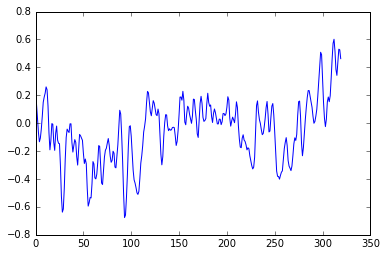

In [8]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [36]:
class RNNTheano:
    
    def __init__(self, out_dim=1, hidden_dim=9, bptt_truncate=4):
        # Assign instance variables
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        V = np.random.normal(0,0.1, (out_dim, hidden_dim))
        W = np.random.normal(0,0.1, (hidden_dim, hidden_dim))
        bW = np.random.normal(0, 0.1, (hidden_dim))
        bV = np.random.normal(0, 0.1, (out_dim))
        velocityV = np.zeros((out_dim, hidden_dim))
        velocitybV = np.zeros(out_dim)
        velocityW = np.zeros((hidden_dim, hidden_dim))
        velocitybW = np.zeros(hidden_dim)
        # Theano: Created shared variables
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX)) 
        self.bV = theano.shared(name='bV', value=bV.astype(theano.config.floatX))
        self.bW = theano.shared(name='bW', value=bW.astype(theano.config.floatX)) 
        self.velocityV = theano.shared(name='velocityV', value=velocityV.astype(theano.config.floatX))
        self.velocityW = theano.shared(name='velocityW', value=velocityW.astype(theano.config.floatX) )
        self.velocitybV = theano.shared(name='velocitybV', value=velocitybV.astype(theano.config.floatX))
        self.velocitybW = theano.shared(name='velocitybW', value=velocitybW.astype(theano.config.floatX)  )
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        V, bV, W, bW= self.V, self.bV, self.W, self.bW

        x = T.vector('x')
        def forward_prop_step(x_t, s_t_prev, V, bV, W, bW):
            s_t = T.tanh(W.dot(s_t_prev)+bW)
            o_t = V.dot(s_t)+bV
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            outputs_info=[None, dict(initial=T.zeros(self.hidden_dim))],
            non_sequences=[V, bV, W, bW],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = o
        o_error = T.mean((x - o) ** 2)
        
        # Gradients
        dV = T.grad(o_error, V)
        dbV = T.grad(o_error, bV)
        dW = T.grad(o_error, W)
        dbW = T.grad(o_error, bW)

        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x], o_error)
        self.bptt = theano.function([x], [dV, dbV, dW, dbW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        momentum= T.scalar('momentum')
                                                          
        self.sgd_step = theano.function([x,learning_rate,momentum], 
                      updates=[(self.velocityV, momentum*self.velocityV - learning_rate * dV),
                               (self.velocitybV, momentum*self.velocitybV - learning_rate * dbV),
                               (self.velocityW, momentum*self.velocityW - learning_rate * dW),
                               (self.velocitybW, momentum*self.velocitybW - learning_rate * dbW),
                               (self.V, self.V + self.velocityV),
                               (self.bV, self.bV + self.velocitybV),
                               (self.W, self.W +self.velocityW),
                               (self.bW, self.bW + self.velocitybW)])
    
    def calculate_loss(self, x):
        return self.ce_error(x)

In [42]:
def train_with_sgd(model, x, learning_rate=0.0001, nepoch=100, momentum=0.95):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        loss = model.calculate_loss(x)
        losses.append(loss)
        # One SGD step
        model.sgd_step(x, learning_rate, momentum)
    return losses


In [43]:
model = RNNTheano()

/usr/local/lib/python3.4/dist-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [44]:
X_train = data[4][:,0]
#X_train = np.ones(320)
losses = train_with_sgd(model, X_train, nepoch=2000)

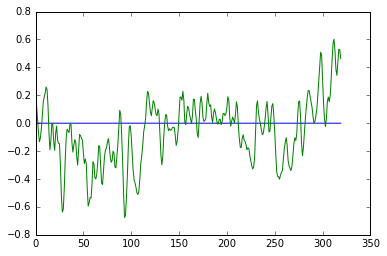

In [45]:
o = model.predict(X_train)
plot(o)
plot(X_train)

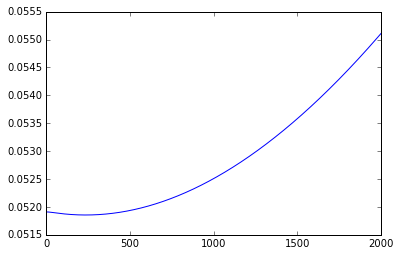

In [46]:
plot(losses)

In [18]:
model.b1[:]

Subtensor{::}.0